# Sea ice analysis

In [1]:
%matplotlib inline
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.DiagsCase import DiagsCase
from ncar_jobqueue import NCARCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import numpy as np
import xarray as xr
from mom6_tools.m6plot import polarplot
import warnings, yaml
warnings.filterwarnings("ignore")

Basemap module not found. Some regional plots may not function properly


In [2]:
# Read in the yaml file
diag_config_yml_path = "diag_config.yml"
diag_config_yml = yaml.load(open(diag_config_yml_path,'r'), Loader=yaml.Loader)

In [3]:
# Create the case instance
dcase = DiagsCase(diag_config_yml['Case'])
print('Casename is:', dcase.casename)

Casename is: g.c2b6.GJRA.TL319_t061.long_JRA_mct.076


In [4]:
# Load the grid
RUNDIR = dcase.get_value('RUNDIR')
grd = MOM6grid(RUNDIR+'/'+dcase.casename+'.mom6.static.nc', xrformat=False)

MOM6 grid successfully loaded... 



In [5]:
# The following parameters must be set accordingly
######################################################
year_start = '0100-01-01'
year_end = '0116-12-31'
# Put your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.start_date = year_start
args.end_date = year_end
args.savefigs = False
args.time_series = True

In [6]:
# Create the climatology instance
cluster = NCARCluster(project='P93300612')
cluster.scale(2)
cluster

In [7]:
client = Client(cluster)
print(cluster.dashboard_link)
client

https://jupyterhub.ucar.edu/ch/user/gmarques/proxy/8787/status


Client Scheduler: tcp://10.148.10.19:46785 Dashboard: https://jupyterhub.ucar.edu/ch/user/gmarques/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [16]:
variables = ['hi', 'aice', 'time']
RUNDIR = dcase.get_value('RUNDIR')

def preprocess(ds):
    '''Return the dataset with variables'''
    return ds[variables] 

%time ds = xr.open_mfdataset(RUNDIR+'/'+dcase.casename+'.cice.h.*.nc', \
         parallel=True, chunks={'time': 12}, data_vars='minimal', \
         preprocess=preprocess)

CPU times: user 1min 19s, sys: 7.99 s, total: 1min 27s
Wall time: 6min 1s


In [17]:
print('\n Selecting data between {} and {}...'.format(args.start_date, args.end_date))
%time ds_sel = ds.sel(time=slice(args.start_date, args.end_date))


 Selecting data between 0100-01-01 and 0116-12-31...
CPU times: user 7.92 ms, sys: 6.13 ms, total: 14.1 ms
Wall time: 14.5 ms


In [18]:
print('\n Computing time mean...')
%time ds_sel_mean = ds_sel.mean('time').compute()


 Computing time mean...
CPU times: user 47.9 s, sys: 1.03 s, total: 48.9 s
Wall time: 2min 39s


In [19]:
print('Computing monthly climatology...')
%time  ds_monthly = ds.groupby("time.month").mean('time').compute()

Computing monthly climatology...
CPU times: user 1min 20s, sys: 1.72 s, total: 1min 22s
Wall time: 4min 22s


In [20]:
# load obs
obs_path = '/glade/work/gmarques/cesm/datasets/Seaice/'
obs_NH = xr.open_dataset(obs_path+'OBS_NSIDC_sat_NH_T2Ms_sic.nc')
obs_SH = xr.open_dataset(obs_path+'OBS_NSIDC_sat_SH_T2Ms_sic.nc')

In [21]:
obs_NH_mean = obs_NH.mean('time').compute()
obs_SH_mean = obs_SH.mean('time').compute()

In [22]:
obs_NH_monthly = obs_NH.groupby("time.month").mean('time').compute()
obs_SH_monthly = obs_SH.groupby("time.month").mean('time').compute()

### Sea ice thickness

#### Annual mean

Text(0.5, 0.98, 'ANN mean sea ice thickness, 0100-01-01 to 0116-12-31')

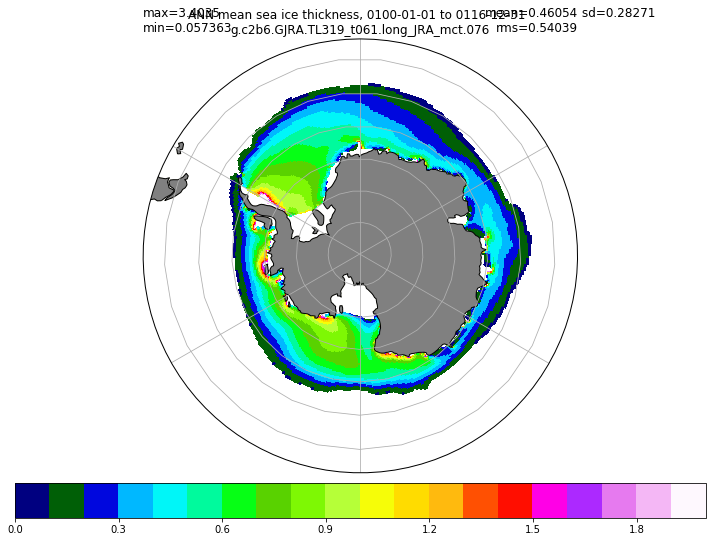

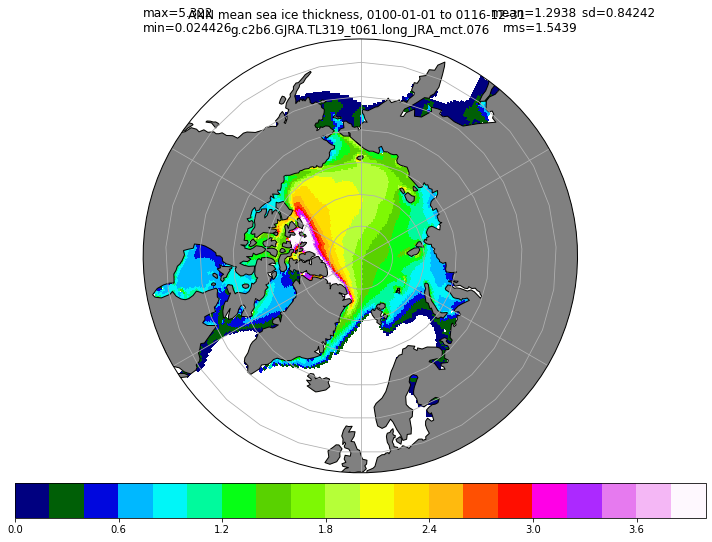

In [23]:
# Sea ice thickness
aice_mean = np.ma.masked_invalid(ds_monthly['aice'].mean('month').values) * 100.
hi_mean = np.ma.masked_invalid(ds_monthly['hi'].mean('month').values)
hi_mean = np.ma.masked_where(aice_mean < 15.0, hi_mean)
suptitle = ('ANN mean sea ice thickness, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(hi_mean, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,2), axis=ax)
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(hi_mean, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,4), axis=ax, proj='NP')
plt.suptitle(suptitle)

#### JFM

Text(0.5, 0.98, 'JFM mean sea ice thickness, 0100-01-01 to 0116-12-31')

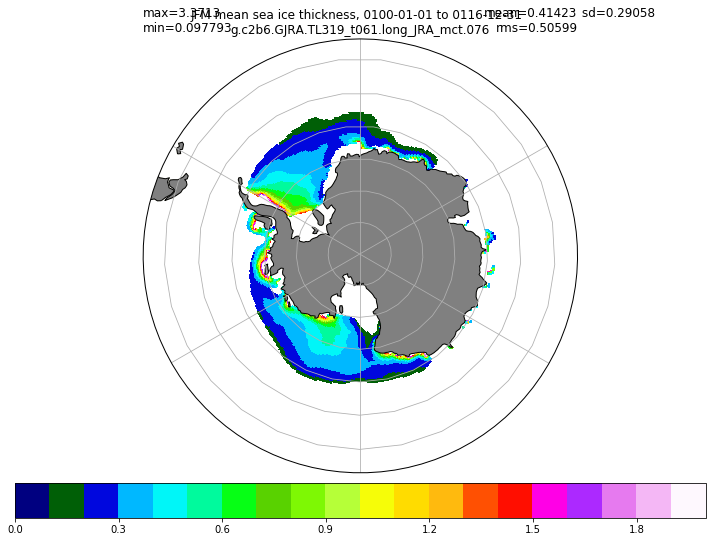

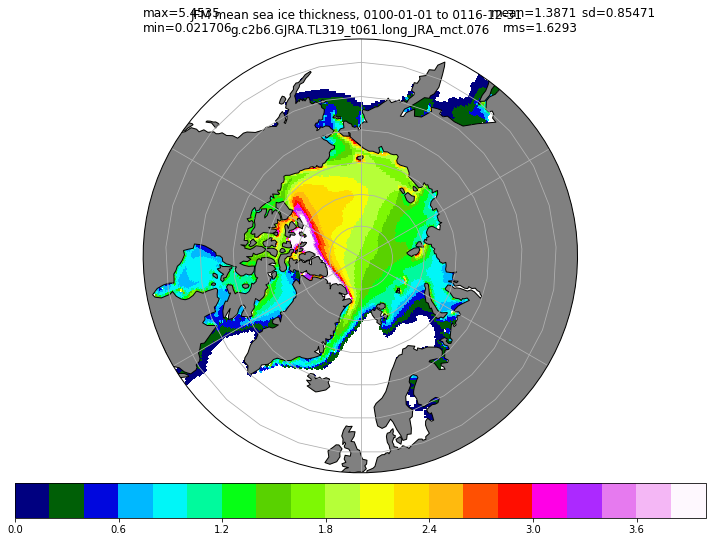

In [24]:
aice_JFM = np.ma.masked_invalid(ds_monthly['aice'].sel(month=[1,2,3]).mean('month').values) * 100.
hi_JFM = np.ma.masked_invalid(ds_monthly['hi'].sel(month=[1,2,3]).mean('month').values)
hi_JFM = np.ma.masked_where(aice_JFM < 15.0, hi_JFM)
suptitle = ('JFM mean sea ice thickness, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(hi_JFM, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,2), axis=ax)
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(hi_JFM, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,4), axis=ax, proj='NP')
plt.suptitle(suptitle)

#### AMJ

Text(0.5, 0.98, 'AMJ mean sea ice thickness, 0100-01-01 to 0116-12-31')

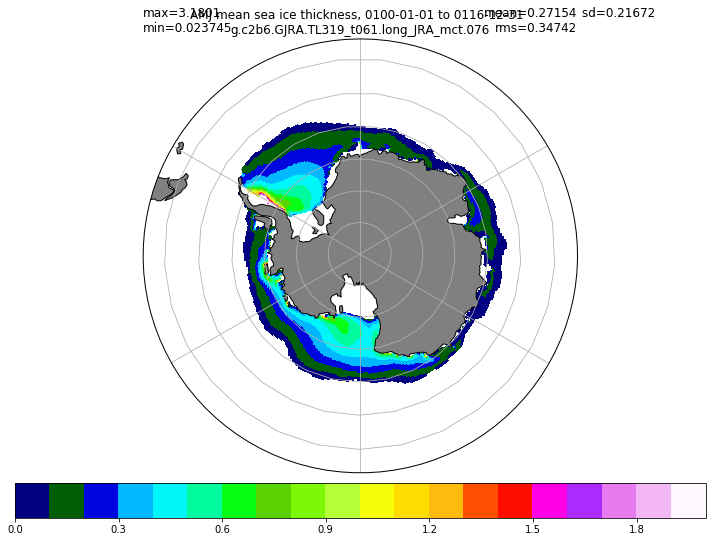

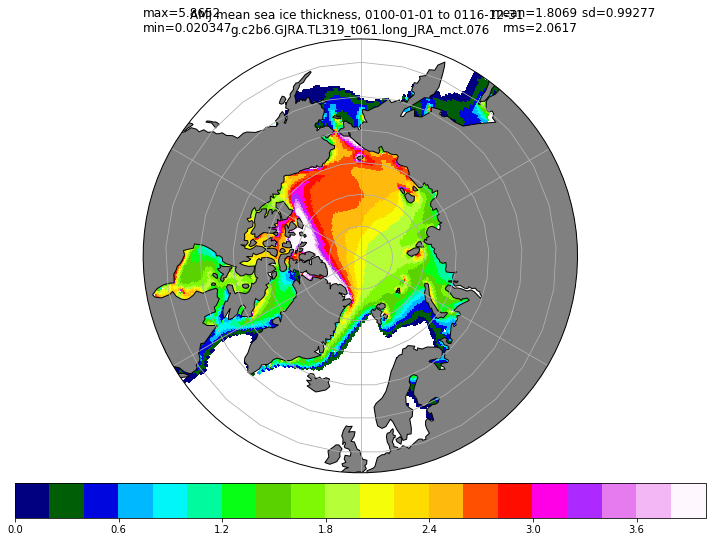

In [25]:
aice_AMJ = np.ma.masked_invalid(ds_monthly['aice'].sel(month=[4,5,6]).mean('month').values) * 100.
hi_AMJ = np.ma.masked_invalid(ds_monthly['hi'].sel(month=[4,5,6]).mean('month').values)
hi_AMJ = np.ma.masked_where(aice_AMJ < 15.0, hi_AMJ)
suptitle = ('AMJ mean sea ice thickness, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline 
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(hi_AMJ, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,2), axis=ax)
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(hi_AMJ, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,4), axis=ax, proj='NP')
plt.suptitle(suptitle)

#### JAS

Text(0.5, 0.98, 'JAS mean sea ice thickness, 0100-01-01 to 0116-12-31')

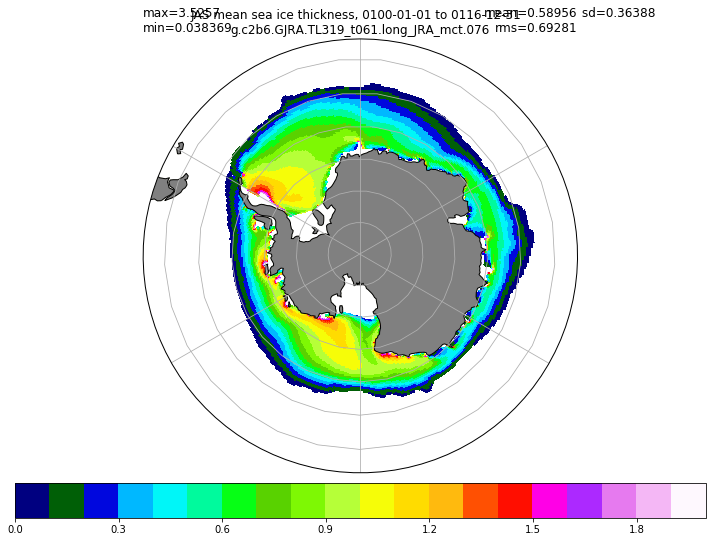

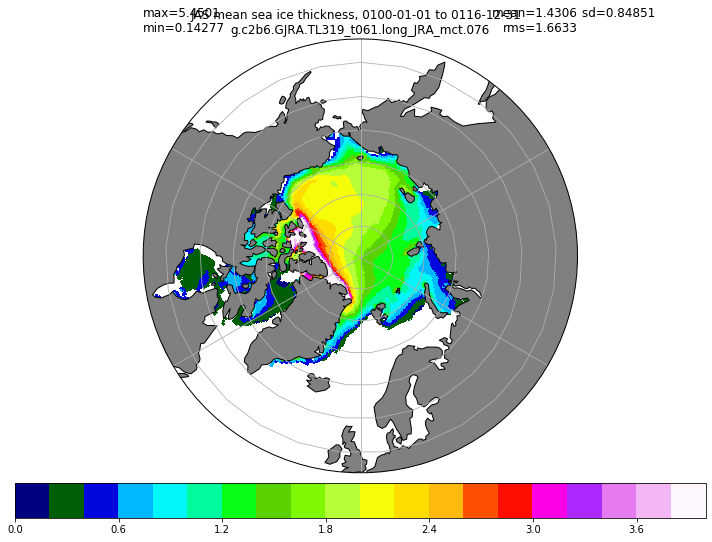

In [26]:
aice_JAS = np.ma.masked_invalid(ds_monthly['aice'].sel(month=[7,8,9]).mean('month').values) * 100.
hi_JAS = np.ma.masked_invalid(ds_monthly['hi'].sel(month=[7,8,9]).mean('month').values)
hi_JAS = np.ma.masked_where(aice_JAS < 15.0, hi_JAS)
suptitle = ('JAS mean sea ice thickness, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline 
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(hi_JAS, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,2), axis=ax)
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(hi_JAS, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,4), axis=ax, proj='NP')
plt.suptitle(suptitle)

#### OND

Text(0.5, 0.98, 'OND mean sea ice thickness, 0100-01-01 to 0116-12-31')

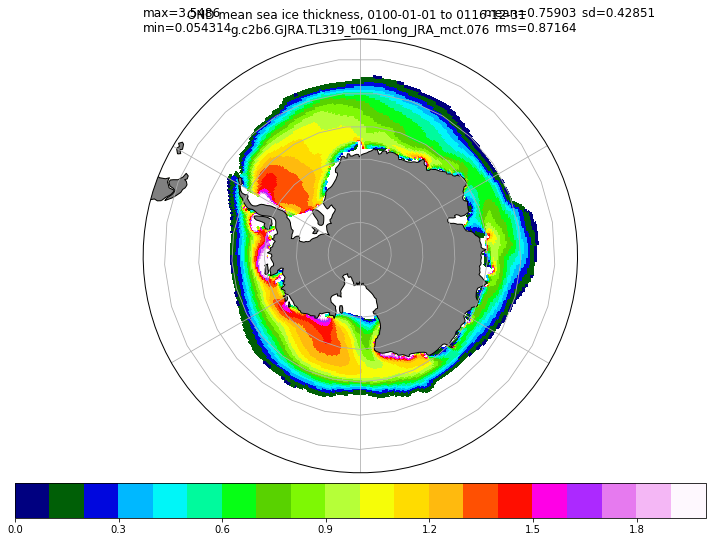

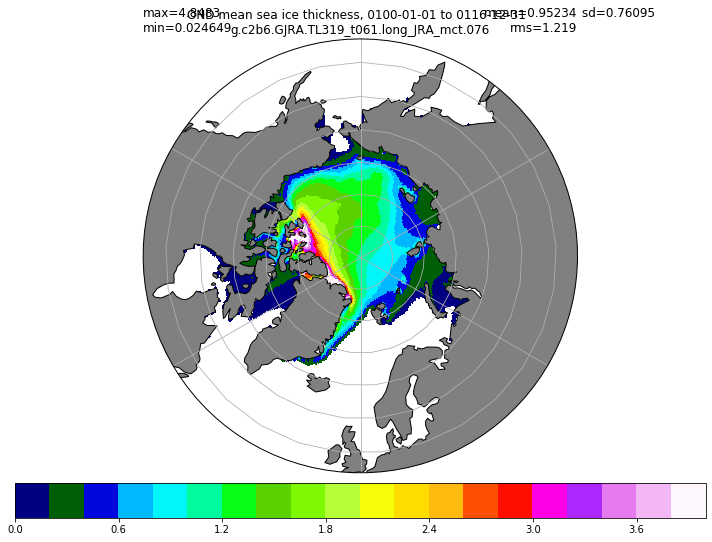

In [27]:
aice_OND = np.ma.masked_invalid(ds_monthly['aice'].sel(month=[10,11,12]).mean('month').values) * 100.
hi_OND = np.ma.masked_invalid(ds_monthly['hi'].sel(month=[10,11,12]).mean('month').values)
hi_OND = np.ma.masked_where(aice_OND < 15.0, hi_OND)
suptitle = ('OND mean sea ice thickness, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline 
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(hi_OND, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,2), axis=ax)
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(hi_OND, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,4), axis=ax, proj='NP')
plt.suptitle(suptitle)

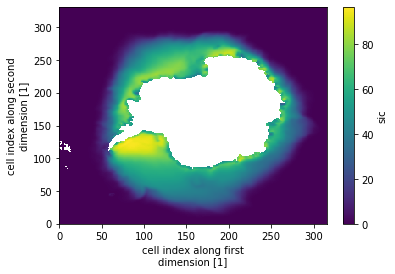

In [28]:
(obs_SH_mean.sic * 100.).plot()

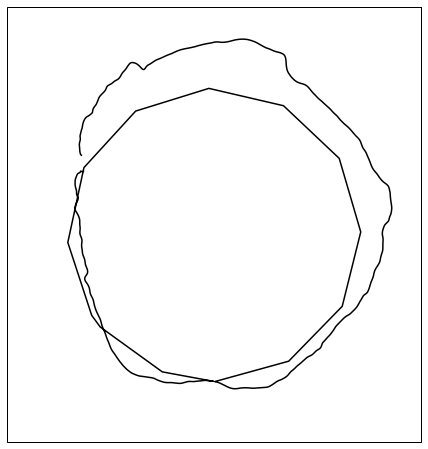

In [30]:
tmp = obs_SH_mean['sic'].values * 100.
#tmp1 = np.ma.masked_where(tmp < 15.0, tmp)
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
ax.contour(obs_SH_mean.lon.values, obs_SH_mean.lat.values, tmp, levels=[16.5], transform=ccrs.PlateCarree(), colors='black')

### Sea ice concentration

Text(0.5, 0.98, 'ANN mean ice concentration, 0100-01-01 to 0116-12-31')

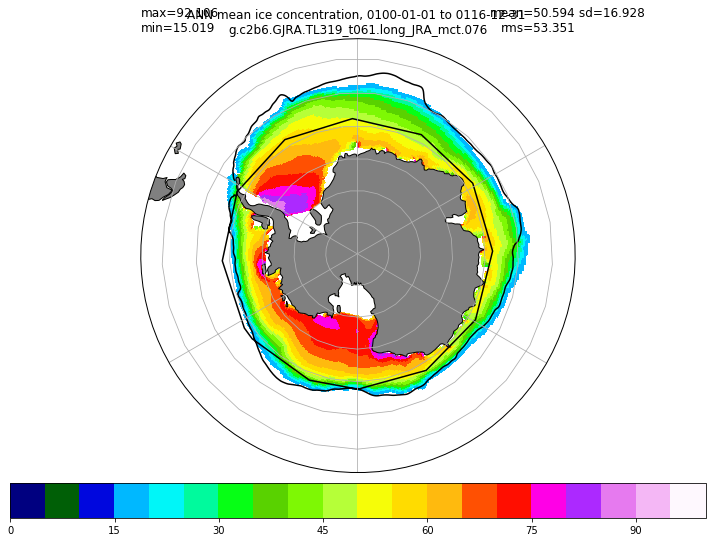

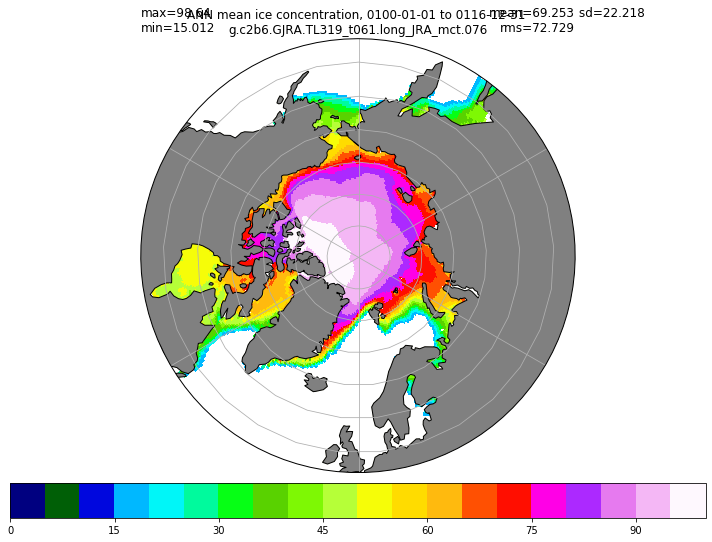

In [32]:

aice_mean = np.ma.masked_where(aice_mean <= 15.0, aice_mean)

suptitle = ('ANN mean ice concentration, ' + str(args.start_date) + ' to ' + str(args.end_date))
%matplotlib inline
# SH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.SouthPolarStereo())
polarplot(aice_mean, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,100), axis=ax)
ax.contour(obs_SH_mean.lon.values, obs_SH_mean.lat.values, tmp, levels=[16.5], transform=ccrs.PlateCarree(), colors='black', 
           linestyles='solid')
plt.suptitle(suptitle)

# NH
fig = plt.figure(figsize=(10,8))
ax = plt.gca(projection=ccrs.NorthPolarStereo())
polarplot(aice_mean, grd, title=dcase.casename, debug=False, colormap=plt.cm.gist_ncar, clim=(0,100), axis=ax, proj='NP')
plt.suptitle(suptitle)

### Northern Hemisphere

## Time series 

### Maximum sea ice thickness 

In [33]:
from mom6_tools.latlon_analysis import create_xarray_dataset, plot_area_ave_stats
from mom6_tools.m6plot import myStats

In [ ]:
dtime = seaice.time.values
# variable name
var = 'hi'
# create datasets
ds_sh = create_xarray_dataset(var,'m',dtime)
ds_nh = create_xarray_dataset(var,'m',dtime)

# loop in time
for t in range(0,len(dtime)):
    # northern hemisphere
    tmp = np.ma.masked_invalid(seaice[var].sel(time=dtime[t]).values)
    tmp_nh = np.ma.masked_where(grd.geolat < 0, tmp)
    # get stats
    sMin, sMax, mean, std, rms = myStats(tmp_nh, area=None)
    # update Dataset
    ds_nh[var][1,t]  = sMax
    # southern hemisphere
    tmp_sh = np.ma.masked_where(grd.geolat > 0, tmp)
    # get stats
    sMin, sMax, mean, std, rms = myStats(tmp_sh, area=None)
    # update Dataset
    ds_sh[var][1,t] = sMax

#### Southern Hemisphere

In [ ]:
sh = ds_sh.sel(stats='max')
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(111)
sh.hi.plot(ax=ax)
plt.title('Maximum sea ice thickness, southern hemisphere', fontsize=14)
plt.xlabel('Time [years]')

#### Northern Hemisphere

In [ ]:
nh = ds_nh.sel(stats='max')
fig = plt.figure(figsize=(12, 6))
ax  = fig.add_subplot(111)
nh.hi.plot(ax=ax)
plt.title('Maximum sea ice thickness, northern hemisphere', fontsize=14)
plt.xlabel('Time [years]')

### Sea ice extent

In [ ]:
dtime = seaice.time.values
# variable name
var = 'aice'
# 
area_sh = []
area_nh = []

# loop in time
for t in range(len(dtime)):
    tmp = np.ma.masked_invalid(seaice[var].sel(time=dtime[t]).values)
    # mask southern hemisphere
    tmp_nh = np.ma.masked_where(grd.geolat < 0, grd.area_t)
    # mask northern hemisphere
    tmp_sh = np.ma.masked_where(grd.geolat > 0, grd.area_t)
    # mask if aggregrated concentration <= 0.15
    tmp_nh = np.ma.masked_where(tmp <= 0.15, tmp_nh*tmp)
    tmp_sh = np.ma.masked_where(tmp <= 0.15, tmp_sh*tmp)
    # append data
    area_sh.append(np.sum(tmp_sh)*1.0e-12) # 1.0e6 km^2
    area_nh.append(np.sum(tmp_nh)*1.0e-12) # 1.0e6 km^2

#### Southern hemisphere

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime,area_sh)
plt.title('Sea ice area, southern hemisphere', fontsize=14)
plt.xlabel('Time [years]', fontsize=14); plt.ylabel('x 1.0e6 km$^2$', fontsize=14)

#### Northern hemisphere

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime,area_nh)
plt.title('Sea ice area, northern hemisphere', fontsize=14)
plt.xlabel('Time [years]', fontsize=14); plt.ylabel('x 1.0e6 km$^2$', fontsize=14)

### Under development

In [ ]:
import matplotlib.path as mpath
fig = plt.figure(figsize=[10, 8])
ice = (seaice.aice[-1,:,:].data)
ax1 = plt.subplot(1, 1, 1, projection=ccrs.NorthPolarStereo())
ax1.set_extent([-180, 180, 50, 90], ccrs.PlateCarree())
ax1.add_feature(cartopy.feature.LAND)
ax1.gridlines()
# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax1.set_boundary(circle, transform=ax1.transAxes)
#colormap = 'rainbow'
cs = ax1.pcolormesh(grd.geolon,grd.geolat,ice,transform=ccrs.PlateCarree(),cmap='Blues_r', shading='flat')
fig.colorbar(cs)
# Add Land
ax1.add_feature( cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='#fae5c9') #fae5c9')
# add Ocean
ax1.add_feature(cartopy.feature.OCEAN)
# Add coastline
ax1.coastlines(color='black')
# Add lat lon rings
ax1.gridlines(alpha='0.1',color='black')
im1 = ax1.contour(grd.geolon,grd.geolat,ice,[15],colors='red', transform=ccrs.PlateCarree())
plt.title('Model, Years ' + str(args.year_start) + ' to ' + str(args.year_end))